
# Fine-tuning YOLO Aquarium
## 1. Mount Drive

In [2]:
from google.colab import drive
import zipfile
import os

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the zip
zip_path = '/content/drive/MyDrive/Aquarium.zip'

# Extract it
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/aquarium-dataset')

Mounted at /content/drive


## 2. Explore files after extracting

In [4]:
# Check structure
!ls /content/aquarium-dataset
!ls /content/aquarium-dataset/test/images | head -5
!ls /content/aquarium-dataset/test/labels | head -5

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid
IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg
IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg
IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg
IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg
IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg
IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.txt
IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.txt
IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.txt
IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.txt
IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.txt


## 3. Visualize image and bounding box

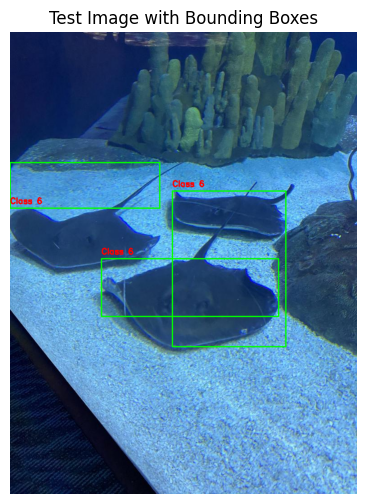

In [5]:
import cv2
import matplotlib.pyplot as plt
import os

# Set paths
img_folder = '/content/aquarium-dataset/test/images'
label_folder = '/content/aquarium-dataset/test/labels'

# Pick an image
# List files in the image folder and pick the first .jpg file found
image_files = [f for f in os.listdir(img_folder) if f.endswith('.jpg')]

if not image_files:
    print("Error: No image files found in the specified directory.")
else:
    img_name = image_files[0] # Pick the first image found
    img_path = os.path.join(img_folder, img_name)
    label_path = os.path.join(label_folder, img_name.replace('.jpg', '.txt'))

    # Load image
    image = cv2.imread(img_path)
    # Check if image was loaded successfully
    if image is None:
        print(f"Error: Could not load image from {img_path}")
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        # Draw bounding boxes
        # Ensure the corresponding label file exists before attempting to open
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    try:
                        cls, x, y, bw, bh = map(float, line.strip().split())
                        # Convert normalized to pixel values
                        x1 = int((x - bw/2) * w)
                        y1 = int((y - bh/2) * h)
                        x2 = int((x + bw/2) * w)
                        y2 = int((x + bh/2) * h)
                        cv2.rectangle(image, (x1, y1), (x2, y2), (0,255,0), 2)
                        cv2.putText(image, f"Class {int(cls)}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
                    except ValueError:
                        print(f"Warning: Skipping malformed line in {label_path}: {line.strip()}")
        else:
            print(f"Warning: No label file found for {img_name} at {label_path}")

        # Show image
        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        plt.title("Test Image with Bounding Boxes")
        plt.axis('off')
        plt.show()

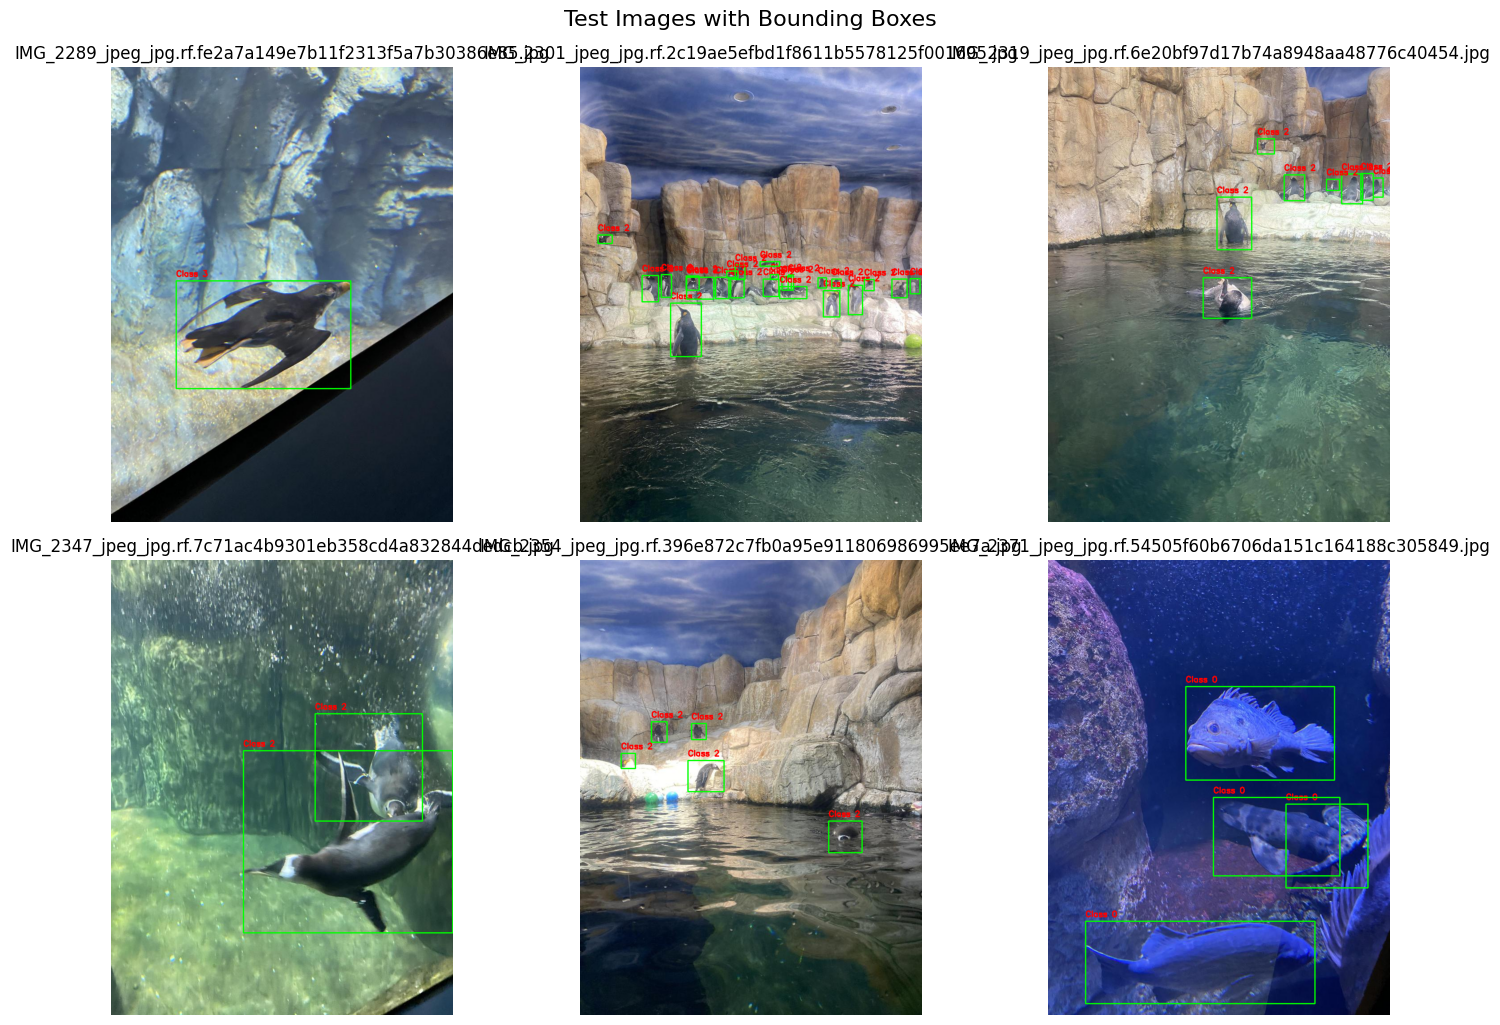

In [6]:

# List image files
image_files = sorted([f for f in os.listdir(img_folder) if f.endswith('.jpg')])

# Number of images to visualize (you can increase this)
n_images = min(6, len(image_files))

# Set up plot grid
plt.figure(figsize=(15, 10))

for idx in range(n_images):
    img_name = image_files[idx]
    img_path = os.path.join(img_folder, img_name)
    label_path = os.path.join(label_folder, img_name.replace('.jpg', '.txt'))

    # Load and convert image
    image = cv2.imread(img_path)
    if image is None:
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # Draw bounding boxes
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                try:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    x1 = int((x - bw/2) * w)
                    y1 = int((y - bh/2) * h)
                    x2 = int((x + bw/2) * w)
                    y2 = int((y + bh/2) * h)
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(image, f"Class {int(cls)}", (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
                except ValueError:
                    continue

    # Plot in a grid
    plt.subplot(2, 3, idx+1)
    plt.imshow(image)
    plt.title(f"{img_name}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Test Images with Bounding Boxes", fontsize=16, y=1.02)
plt.show()


## 4. Set Up YOLOv5 for Fine-Tuning
* I used Ultralytics YOLOv5, which is stable, fast, and easy to fine-tune.

In [7]:
# Clone YOLOv5 repo and install requirements
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17485, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 17485 (delta 78), reused 30 (delta 30), pack-reused 17378 (from 3)
Receiving objects: 100% (17485/17485), 16.35 MiB | 20.05 MiB/s, done.
Resolving deltas: 100% (11989/11989), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/

## 5. Verify dataset structure and data.yaml
* first chech the classes number and ids
* then i checked each class's name

In [8]:
import os

label_dir = '/content/aquarium-dataset/train/labels'  # or valid/test/labels
class_ids = set()

# Loop through all label files
for filename in os.listdir(label_dir):
    if filename.endswith('.txt'):
        with open(os.path.join(label_dir, filename), 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    class_ids.add(int(parts[0]))

# Sort and display
class_ids = sorted(list(class_ids))
print("Unique class IDs found:", class_ids)
print("Total classes (nc):", len(class_ids))


Unique class IDs found: [0, 1, 2, 3, 4, 5, 6]
Total classes (nc): 7


In [9]:
with open('/content/aquarium-dataset/data.yaml', 'r') as f:
    print(f.read())

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 7
names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']

roboflow:
  workspace: brad-dwyer
  project: aquarium-combined
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/brad-dwyer/aquarium-combined/dataset/2


## 6. Created the data.yaml file

In [10]:
data_yaml_content = """
train: /content/aquarium-dataset/train/images
val: /content/aquarium-dataset/valid/images

nc: 7
names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']
"""

# Write to file
with open('/content/aquarium-dataset/data.yaml', 'w') as f:
    f.write(data_yaml_content)

# Confirm the content
with open('/content/aquarium-dataset/data.yaml', 'r') as f:
    print(f.read())



train: /content/aquarium-dataset/train/images
val: /content/aquarium-dataset/valid/images

nc: 7
names: ['fish', 'jellyfish', 'penguin', 'puffin', 'shark', 'starfish', 'stingray']



## 7. Set up augmentation inside training

* WHY?
* **Horizontal Flip:** Fish and other aquarium objects can appear facing either left or right, so flipping helps the model generalize across orientations.

* **Random Brightness & Contrast:** Aquarium lighting varies, so this simulates different light conditions for robustness.

* **Shift, Scale & Rotate:** Slight positional and size changes plus mild rotation simulate natural variance and camera angle differences.



In [11]:
import albumentations as A
import cv2
import os
from shutil import copyfile

# Paths
train_img_dir = '/content/aquarium-dataset/train/images'
train_lbl_dir = '/content/aquarium-dataset/train/labels'

aug_img_dir = '/content/aquarium-dataset/train_aug/images'
aug_lbl_dir = '/content/aquarium-dataset/train_aug/labels'

os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_lbl_dir, exist_ok=True)

# Albumentations transform: Flip + Brightness/Contrast + Scale
transform = A.Compose([
    A.HorizontalFlip(p=1.0),  # Flip horizontally, useful because fish can appear on either side
    A.RandomBrightnessContrast(p=0.7),  # Simulates different lighting in the aquarium
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),  # Slight shift, scale, rotation
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

image_files = [f for f in os.listdir(train_img_dir) if f.endswith('.jpg')]

for img_name in image_files:
    img_path = os.path.join(train_img_dir, img_name)
    label_path = os.path.join(train_lbl_dir, img_name.replace('.jpg', '.txt'))

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    # Load labels in YOLO format (class, x_center, y_center, width, height)
    bboxes = []
    class_labels = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            cls, x, y, bw, bh = map(float, line.strip().split())
            bboxes.append([x, y, bw, bh])
            class_labels.append(int(cls))

    # Apply augmentation
    augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    aug_img = augmented['image']
    aug_bboxes = augmented['bboxes']
    aug_labels = augmented['class_labels']

    # Save augmented image
    aug_img_name = img_name.replace('.jpg', '_aug.jpg')
    aug_img_path = os.path.join(aug_img_dir, aug_img_name)
    aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(aug_img_path, aug_img_bgr)

    # Save augmented labels
    aug_label_path = os.path.join(aug_lbl_dir, aug_img_name.replace('.jpg', '.txt'))
    with open(aug_label_path, 'w') as f:
        for cls, bbox in zip(aug_labels, aug_bboxes):
            bbox_str = ' '.join([f'{x:.6f}' for x in bbox])
            f.write(f"{cls} {bbox_str}\n")

    # Also copy original image and label (optional, you can keep original data as well)
    copyfile(img_path, os.path.join(aug_img_dir, img_name))
    copyfile(label_path, os.path.join(aug_lbl_dir, img_name.replace('.jpg', '.txt')))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


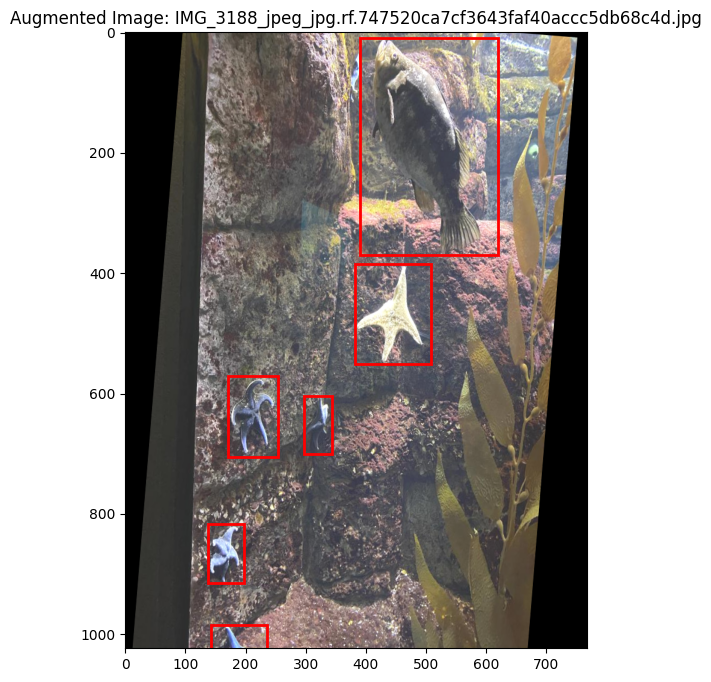

In [12]:
import matplotlib.patches as patches

# Visualize augmented image and bboxes
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(aug_img)

for bbox in aug_bboxes:
    # YOLO format to pixel coords
    x_c, y_c, bw, bh = bbox
    x = (x_c - bw/2) * w
    y = (y_c - bh/2) * h
    bw_pix = bw * w
    bh_pix = bh * h

    rect = patches.Rectangle((x, y), bw_pix, bh_pix, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.title(f'Augmented Image: {img_name}')
plt.show()


In [13]:
!python train.py --img 640 --batch 16 --epochs 30 \
--data /content/aquarium-dataset/data.yaml \
--weights yolov5s.pt --cache

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-05-16 12:53:47.196361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747400027.479997    1460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747400027.558129    1460 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

## 8. Output

In [16]:
print('/content/yolov5/runs/train/exp')

/content/yolov5/runs/train/exp


## 9. Evaluate Performance

In [17]:
!python val.py --weights runs/train/exp/weights/best.pt --data /content/aquarium-dataset/data.yaml --img 640

val: data=/content/aquarium-dataset/data.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7029004 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/aquarium-dataset/valid/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100% 127/127 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:06<00:00,  1.65s/it]
                   all        127        909      0.786      0.688       0.73       0.42
                  fish        127        459      0.801      0.806      0.843      0.456
            

## OBSERVATION

Data augmentation **enhances** bounding box accuracy by increasing the **diversity and variability** of training samples,
 enabling the model:

 to generalize better across different spatial transformations and lighting conditions;

this leads to improved robustness and precision in object localization.